# __Capstone Final Project__

## Determining the ideal neighborhood for a coffee shop in Toronto

### Importing libraries

In [4]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [5]:
# A csv file of the wikipedia data was made from an online converter (https://wikitable2csv.ggor.de/) and then uploaded to my repository. I then load it here
url = 'https://raw.githubusercontent.com/awar667/Capstone-Repository/master/wiki-csv'
df = pd.read_csv(url, error_bad_lines=False)

### Eliminating Not Assigned Rows, Grouping by Postcode

In [6]:
df2 = df[df.Borough != 'Not assigned']

In [7]:
df3 = df2.groupby('Postcode').agg({'Borough' : 'first', 'Neighbourhood' : ', '.join}).reset_index().reindex(columns=df.columns)

### Obtaining Latitude/Longitude Values and Merging to Table

In [8]:
# get geo data
url2 = "https://cocl.us/Geospatial_data"
dfa = pd.read_csv(url2, error_bad_lines=False)
dfa.rename(columns = {'Postal Code':'Postcode'}, inplace = True)

In [9]:
merged = pd.merge(df3,dfa, on ='Postcode')

### Retrieving Venue Data From Foursquare

In [10]:
CLIENT_ID = 'OJXC4W4QFQGNY2YD2FECJESEC5I0WAAGFAODZUVZ2M0QLTVY' 
CLIENT_SECRET = 'SWTN20JFMIZOXYDSLGLEAT0WBB3END2LC3SNXR3EBQEAHH2N'
VERSION = '20180605'

In [11]:
neighborhood_latitude = merged.loc[0, 'Latitude'] 
neighborhood_longitude = merged.loc[0, 'Longitude']
neighborhood_name = merged.loc[0, 'Neighbourhood']

In [12]:
LIMIT = 100
radius = 500

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [13]:
nr = requests.get(url3).json()

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = nr['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Toronto_venues = getNearbyVenues(names=merged['Neighbourhood'], latitudes=merged['Latitude'], longitudes=merged['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

### Sample of Venue List

In [90]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


### Merging Venue Categories for Each Neighborhood

In [30]:
t_agg = Toronto_venues.groupby('Neighborhood').agg({'Venue Category' : ', '.join})

In [89]:
t_agg.head()

,Venue Category
Neighborhood,
"Adelaide, King, Richmond","Concert Hall, Vegetarian / Vegan Restaurant, S..."
Agincourt,"Breakfast Spot, Lounge, Latin American Restaur..."
"Agincourt North, L'Amoreaux East, Milliken, Steeles East","Park, Playground"
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown","Pharmacy, Sandwich Place, Fried Chicken Joint,..."
"Alderwood, Long Branch","Pizza Place, Gym, Pub, Coffee Shop, Pizza Plac..."


### Counting & Displaying Number of Coffee Shops per Neighborhood

In [88]:
cof = pd.DataFrame({'Neighborhood': [], '# Coffee Shops': []})

for index, row in t_agg.iterrows():
    t0 = row.str.count('Coffee Shop')
    cof = cof.append({'Neighborhood': index, '# Coffee Shops': int(t0)}, ignore_index = True)
cof.head()

,Neighborhood,# Coffee Shops
0,"Adelaide, King, Richmond",7.0
1,Agincourt,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",1.0
4,"Alderwood, Long Branch",1.0


In [92]:
# Counting number of venues per neighborhood
num_ven = Toronto_venues.groupby('Neighborhood').count()

### Dividing the Number of Coffee Shops by the Number of Venues for Each Neighborhood to Determine the Percentage of Venues that are Coffee Shops

In [93]:
final = pd.DataFrame({'Neighborhood': [], '% Coffee Shops': [], '# Venues': []})

n = 0
for index, row in num_ven.iterrows():
    t2 = cof.iloc[n,1]/num_ven.iloc[n,1]
    final = final.append({'Neighborhood': index, '% Coffee Shops': t2, '# Venues': num_ven.iloc[n,1]}, ignore_index = True)
    n = n + 1
final.head()    

,Neighborhood,% Coffee Shops,# Venues
0,"Adelaide, King, Richmond",0.070000,100.0
1,Agincourt,0.000000,5.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,2.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.100000,10.0
4,"Alderwood, Long Branch",0.111111,9.0


### Obtaining the Highest Number of Venues and the Highest Ratio of Coffee Shops to Venues

In [73]:
max_num = final['# Venues'].max()
max_num

100.0

In [75]:
max_per = final['% Coffee Shops'].max()
max_per

0.6666666666666666

### Plot of the Relationship between the Total Number of Venues and the Percentage of Venues that are Coffee Shops

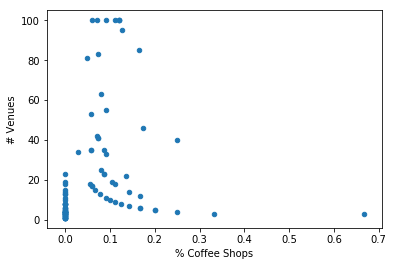

In [77]:
map0 = final.plot.scatter('% Coffee Shops', '# Venues')
map0

### Determining the Score: Which Location Best Combines a High Number of Venues (Consumer Activity) and a Low Percentage of Coffee Shops

In [82]:
s_final = pd.DataFrame({'Neighborhood': [], 'Score': []})

m = 0
for index, row in num_ven.iterrows():
    t3 = 0.5*(final.iloc[m,2]/max_num +(1/max_per)*(max_per-final.iloc[m,1])) # This formula equally weighs the number of venues and the percentage of venues that are coffee shops, where the closer a neighborhood comes to the highest number of venues and the farther away it gets from the highest perceptage of coffee shops, the closer its score will be to 1.
    s_final = s_final.append({'Neighborhood': index, 'Score': t3}, ignore_index = True)
    m = m + 1
s_final

,Neighborhood,Score
0,"Adelaide, King, Richmond",0.947500
1,Agincourt,0.525000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.510000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.475000
4,"Alderwood, Long Branch",0.461667
5,"Bathurst Manor, Downsview North, Wilson Heights",0.506667
6,Bayview Village,0.520000
7,"Bedford Park, Lawrence Manor East",0.565000
8,Berczy Park,0.706818
9,"Birch Cliff, Cliffside West",0.520000


## Finally, We Determine the Ideal Location of a Coffee Shop Based on which Neighborhood Came Closest to a Score of 1

In [87]:
max_s = s_final['Score'].max()
ideal_loc = s_final[s_final['Score'] == max_s]
ideal_loc

,Neighborhood,Score
81,St. James Town,0.955


# ANSWER: St. James Town